This notebook provides some examples on how to interact programmatically with the `MFLike` likelihood.



## Preamble



In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cobaya
import camb
print("     Numpy :", np.__version__)
print("Matplotlib :", mpl.__version__)
print("      CAMB :", camb.__version__)
print("    Cobaya :", cobaya.__version__)

     Numpy : 1.18.1
Matplotlib : 3.1.2
      CAMB : 1.1.0
    Cobaya : 2.1.0


## Loading & getting the MFLike likelihood from cobaya



We first set the default values of CMB and nuisance parameters



In [2]:
cosmo_params = {
    "cosmomc_theta": 0.0104085,
    "logA": {"value": 3.044, "drop": True},
    "As": {"value": "lambda logA: 1e-10*np.exp(logA)"},
    "ombh2": 0.02237,
    "omch2": 0.1200,
    "ns": 0.9649,
    "Alens": 1.0,
    "tau": 0.0544
}
nuisance_params = {
    "a_tSZ": 3.30,
    "a_kSZ": 1.60,
    "a_p": 6.90,
    "beta_p": 2.08,
    "a_c": 4.90,
    "beta_c": 2.20,
    "n_CIBC": 1.20,
    "a_s": 3.10,
    "T_d": 9.60
}

Then we declare our likelihood



In [3]:
mflike_config = {
    "mflike.MFLike": {
        "input_file": "data_sacc_00000.fits",
        "cov_Bbl_file": "data_sacc_w_covar_and_Bbl.fits"
    }
}

We will need to download and install [`LAT_MFLike_data`](https://github.com/simonsobs/LAT_MFLike_data). Here we will do it programatically in such a
way we can use this notebook without any prerequisites. Code and data will be stored in the `/tmp`
directory for the tutorial purpose but feel free to change it to whatever location you want. By the
way the next command will take some times to proceed



In [4]:
from cobaya.install import install
install({"likelihood": mflike_config}, path="/tmp/modules")

[install] Installing modules at '/tmp/modules'

likelihood:mflike.MFLike

[install] External module already installed.

[install] Doing nothing.



We finally put everything into a dictionary to push it into `cobaya` configuration system



In [5]:
info = {
    "params": {**cosmo_params, **nuisance_params},
    "likelihood": mflike_config,
    "theory": {"camb": {"extra_args": {"lens_potential_accuracy": 1}}},
    "modules": "/tmp/modules"
}

We will now get the model given the above parameters



In [6]:
from cobaya.model import get_model
model = get_model(info)

[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] *local* CAMB not found at /tmp/modules/code/CAMB
[camb] Importing *global* CAMB.
[mflike.mflike] Initialising.


To get a direct acces to the `MFLike` likelihood instance, we can retrieve it from the collection of
likelihoods of `cobaya` given its name (so far there is only our likelihood)



In [7]:
mflike = model.likelihood["mflike.MFLike"]

We can now play with the different data (Bbl, inverted covariance matrix) and we can also call the
different methods such as `_get_foreground_model` to see what foreground model look likes.



## Getting likelihood value given current parameter set



We can retrieve informations related to likelihood(s) as follow



In [8]:
loglikes, derived = model.loglikes({})
print("log-likelihood value = {}, derived parameter value (As) = {}".format(loglikes, derived))

log-likelihood value = [-1470.11149929], derived parameter value (As) = [2.0989031673191437e-09]


We can also use the `evaluate` sampler that evaluates the log-likelihood at a given reference point :
here, since parameters are all fixed, it computes the log-likelihood value.



In [9]:
info["sampler"] = {"evaluate": None}
from cobaya.run import run
updated_info, products = run(info)

[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] *local* CAMB not found at /tmp/modules/code/CAMB
[camb] Importing *global* CAMB.
[mflike.mflike] Initialising.
[evaluate] Initialized!
[evaluate] Looking for a reference point with non-zero prior.
[evaluate] Reference point:
   
[evaluate] Evaluating prior and likelihoods...
[evaluate] log-posterior  = -1470.11
[evaluate] log-prior      = 0
[evaluate]    logprior_0 = 0
[evaluate] log-likelihood = -1470.11
[evaluate]    chi2_mflike.MFLike = 2940.22
[evaluate] Derived params:
[evaluate]    As = 2.0989e-09


Finally, we can directly catch the value returned by `logp` function from `MFLike` likelihood



In [10]:
logp = mflike.logp(**nuisance_params)
print("log-likelihood value =", logp)
print("Χ² value =", -2*logp)

log-likelihood value = -1470.1114992920197
Χ² value = 2940.2229985840395


## Plotting CMB power spectra



Here we get $C_\ell$ for different mode and a different range of [&ell;<sub>min</sub>;&ell;<sub>max</sub>] than the
default range of `MFLike`. Make sure to call the `model.logposterior` line with the `cached=False`
option in order to recompute $C_\ell$s given the new &ell; range.



In [11]:
lmin, lmax = 2, 9000
Cl = {"tt": lmax, "ee": lmax, "te": lmax, "bb":lmax}
model.theory["camb"].needs(Cl=Cl)
model.logposterior({})
Dls = model.theory["camb"].get_Cl(ell_factor=True)

Let's plot the different spectra



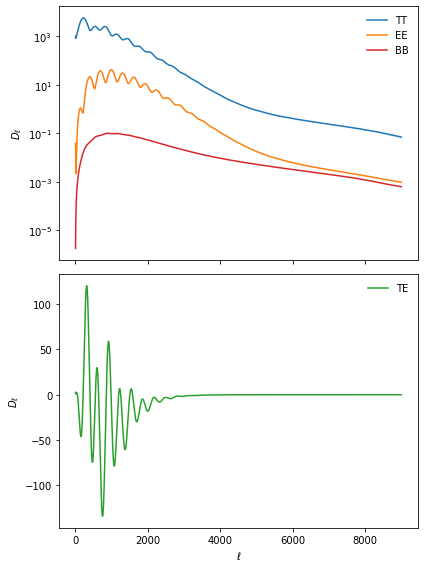

In [12]:
ell = np.arange(lmin, lmax)
dls = {cl: Dls[cl][lmin:lmax] for cl in Cl.keys()}
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 8))
axes[0].set_yscale("log")
for i, cl in enumerate(Cl.keys()):
    ax = axes[1] if cl == "te" else axes[0]
    ax.plot(ell, dls[cl], "-C{}".format(i), label=cl.upper())

for ax in axes:
    ax.set_ylabel(r"$D_\ell$")
    ax.legend()
    axes[1].set_xlabel(r"$\ell$")
    plt.tight_layout()

## Plotting foregrounds



Get all the foreground models at higher &ell;



In [13]:
from mflike import get_foreground_model
fg_models = get_foreground_model(nuisance_params, mflike.foregrounds, mflike.freqs, ell=ell)

Then plot them in a triangle plot



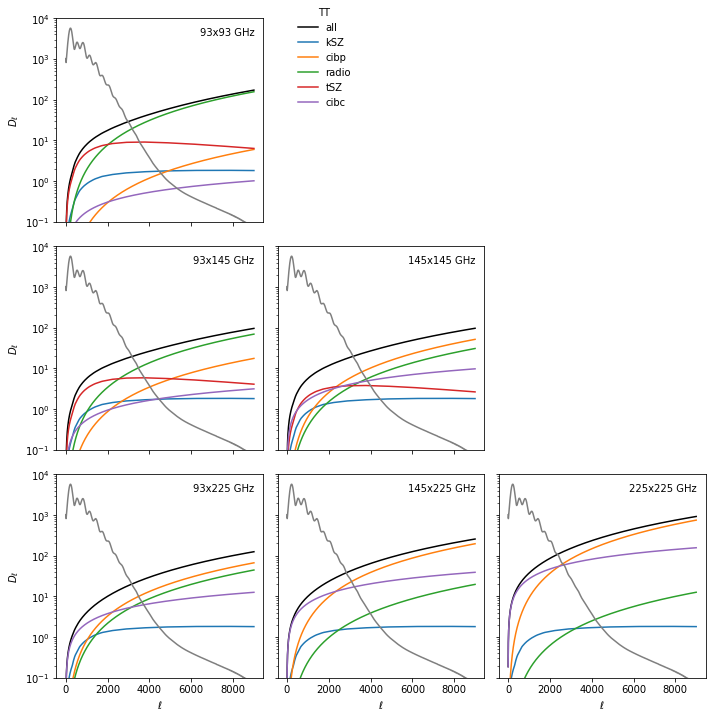

In [14]:
mode = "tt"
components = mflike.foregrounds["components"][mode]
freqs = sorted(mflike.freqs)
nfreqs = len(freqs)
fig, axes = plt.subplots(nfreqs, nfreqs, sharex=True, sharey=True, figsize=(10, 10))
from itertools import product
for i, cross in enumerate(product(freqs, freqs)):
    idx = (i%nfreqs, i//nfreqs)
    ax = axes[idx]
    if idx in zip(*np.triu_indices(nfreqs, k=1)):
      fig.delaxes(ax)
      continue
    ax.plot(ell, fg_models[mode, "all", cross[0], cross[1]], color="k")
    for compo in components:
      ax.plot(ell, fg_models[mode, compo, cross[0], cross[1]])
    ax.plot(ell, dls[mode], color="tab:gray")
    ax.legend([], title="{}x{} GHz".format(*cross))
    if mode == "tt":
      ax.set_yscale("log")
      ax.set_ylim(10**-1, 10**4)

for i in range(nfreqs):
  axes[-1, i].set_xlabel("$\ell$")
  axes[i, 0].set_ylabel("$D_\ell$")
fig.legend(["all"] + components, title=mode.upper(), bbox_to_anchor=(0.5, 1))
plt.tight_layout()

## Plotting simulations & residuals



Simulations and covariance are stored as `sacc` objects. Here we will read the power spectra for all
the simulations and compare its mean value to theory + foregrounds. For more details regarding `sacc`
format, you can have a look to the tutorial [notebooks](https://github.com/simonsobs/sacc/tree/master/examples) or you can refer to the official [documentation](https://sacc.readthedocs.io/en/latest/)

Here we define function utilities related to `sacc` files



In [15]:
import os
import sacc
def _get_tracers(spec, cross):
    spins = {"t": ("0", "s0"), "e": ("e", "s2"), "b": ("b", "s2")}
    data_type = "cl_{}{}".format(spins[spec[0]][0], spins[spec[1]][0])
    tracers = ["LAT_{}_{}".format(cross[i], spins[spec[i]][1]) for i in range(2)]
    return data_type, *tracers
def read_sacc_data(spec, cross, sim_id):
    fn = os.path.join(mflike.data_folder, "data_sacc_{:05d}.fits".format(sim_id))
    s = sacc.Sacc.load_fits(fn)
    return s.get_ell_cl(*_get_tracers(spec, cross))
def read_sacc_cov(spec, cross):
    fn = os.path.join(mflike.data_folder, "data_sacc_w_covar_and_Bbl.fits")
    s_b = sacc.Sacc.load_fits(fn)
    return s_b.get_ell_cl(*_get_tracers(spec, cross), return_cov=True, return_windows=True)[-2:]

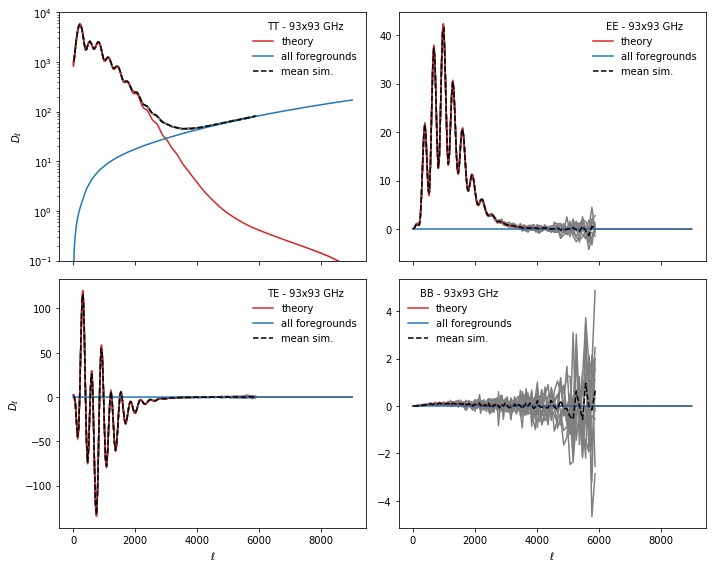

In [16]:
cross = (93, 93)
nsims = 10

fig, axes = plt.subplots(2, 2, sharex=True, figsize=(10, 8))
for spec, ax in zip(Cl.keys(), axes.flatten()):
    cls = []
    for i in range(nsims):
        cls += [read_sacc_data(spec, cross, i)]
        ax.plot(*cls[-1], color="tab:gray")
    ax.plot(ell, dls[spec], color="tab:red", label="theory")
    fg = fg_models[spec, "all", cross[0], cross[1]] if spec != "bb" else np.zeros_like(ell)
    ax.plot(ell, fg, color="tab:blue", label="all foregrounds")
    ax.plot(*np.mean(cls, axis=0), "--k", label="mean sim.")
    ax.legend(title="{} - {}x{} GHz".format(spec.upper(), *cross))
    if spec == "tt":
      ax.set_yscale("log")
      ax.set_ylim(10**-1, 10**4)

for ax in axes[:, 0]:
    ax.set_ylabel(r"$D_\ell$")
for ax in axes[-1]:
    ax.set_xlabel(r"$\ell$")
plt.tight_layout()

We can also plot the residuals *i.e.* simulations - (theory + foregrounds) for the different spectra
and cross frequencies (we have to take care of the &ell; range of Bbl and cut power spectra
consequently)



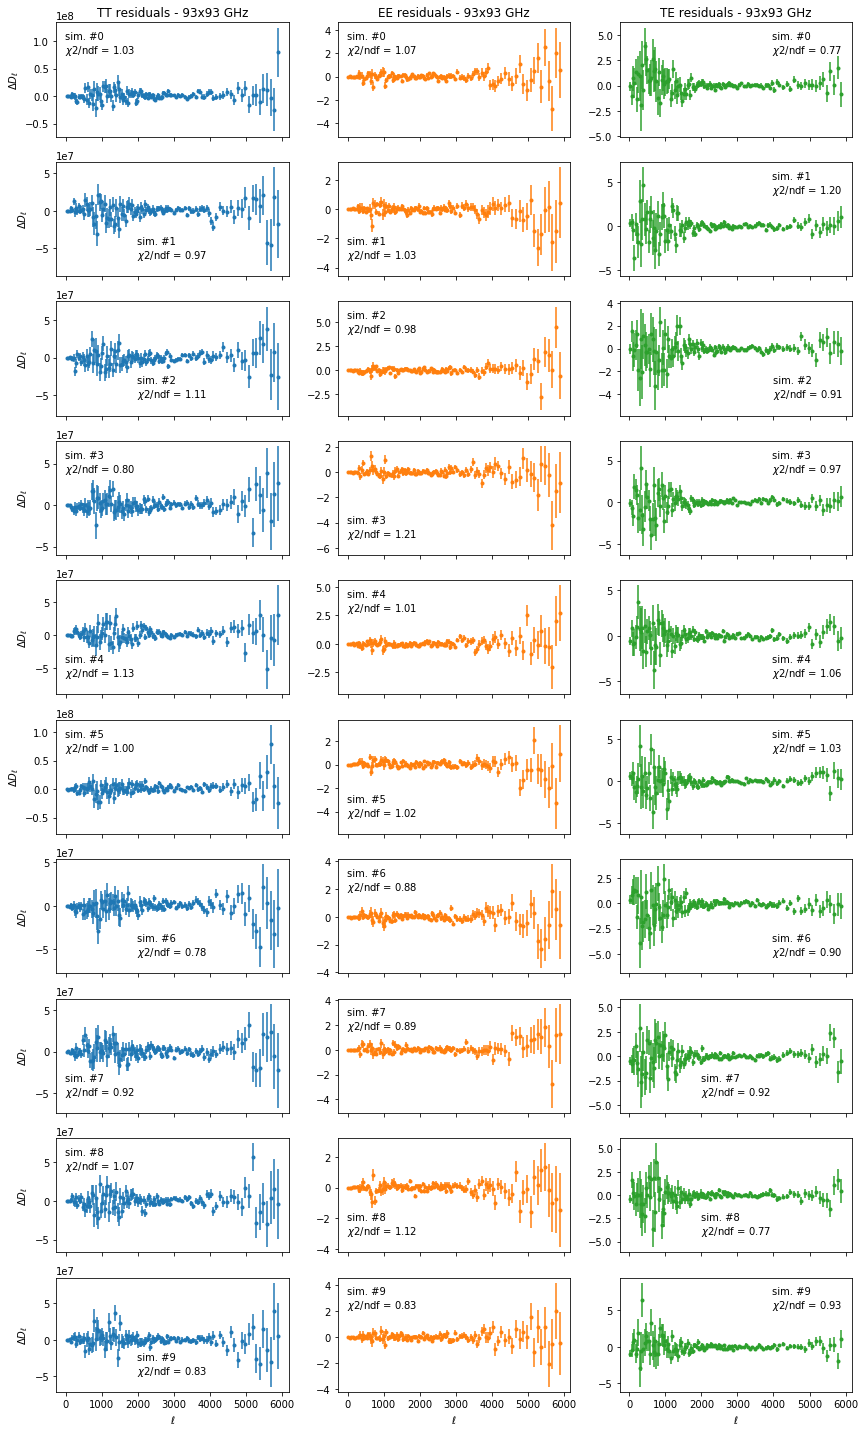

In [17]:
spectra = ["tt", "ee", "te"]

# Get binned theory + fg
theory = {}
for spec in spectra:
    cov, bbl = read_sacc_cov(spec, cross)
    ps_th = dls[spec]
    ps_fg = fg_models[spec, "all", cross[0], cross[1]]
    theory.update({spec: {"cl": np.dot(bbl[1], ps_th[:6000]+ps_fg[:6000]),
                          "error": np.sqrt(np.diag(cov))}})

fig, axes = plt.subplots(nsims, 3, sharex=True, figsize=(12, 2*nsims))
for i in range(nsims):
    for j, spec in enumerate(spectra):
        l, cl = read_sacc_data(spec, cross, i)
        x, y, yerr = l, cl - theory[spec]["cl"], theory[spec]["error"]
        if spec == "tt":
            axes[i, j].errorbar(x, x**2*y, x**2*yerr, fmt=".C{}".format(j))
        else:
            axes[i, j].errorbar(x, y, yerr, fmt=".C{}".format(j))
        chi2 = np.sum((y/yerr)**2)
        title = "sim. #%i\n$\chi2$/ndf = %.2f" % (i, chi2/len(y))
        axes[i, j].legend([], title=title)

for ax in axes[:, 0]:
    ax.set_ylabel(r"$\Delta D_\ell$")
for ax in axes[-1]:
    ax.set_xlabel(r"$\ell$")
for i, spec in enumerate(spectra):
    axes[0, i].set_title(r"{} residuals - {}x{} GHz".format(spec.upper(), *cross))
plt.tight_layout()

## Fisher matrix



Even if we do not need priors to compute Fisher matrix, we need to fool `cobaya` in order to change
parameter values. We set the prior values to &plusmn; 10% arround the central value. We need to take care
of `logA` parameter since `cobaya` will sample it but theory module will use the derivative `As` value.



In [18]:
sampled_params = {**cosmo_params, **nuisance_params}.copy()
sampled_params.update({k: {"prior": {"min": 0.9*v, "max": 1.1*v}}
                       for k, v in sampled_params.items() if k not in ["logA", "As"]})
sampled_params["logA"] = {"prior": {"min": 0.9*cosmo_params["logA"]["value"],
                                    "max": 1.1*cosmo_params["logA"]["value"]},
                          "drop": True}

Then we define a new model (after having close the previous one to release memory allocation) and
get the `MFLike` likelihood



In [19]:
model.close()
info = {
    "params": sampled_params,
    "likelihood": mflike_config,
    "theory": {"camb": {"extra_args": {"lens_potential_accuracy": 1}}},
    "modules": "/tmp/modules"
}
from cobaya.model import get_model
model = get_model(info)
mflike = model.likelihood["mflike.MFLike"]

[camb] *local* CAMB not found at /tmp/modules/code/CAMB
[camb] Importing *global* CAMB.
[mflike.mflike] Initialising.


Given the sampled parameters, we now set the defaults value of parameters in the same order as the
`cobaya`'s one



In [20]:
default_values = {**cosmo_params, **nuisance_params}.copy()
default_values["logA"] = cosmo_params["logA"]["value"]
defaults = {k: default_values[k] for k in model.parameterization.sampled_params().keys()}

and we define the list of Fisher parameters



In [21]:
fisher_params = list(defaults.keys())
for p in ["tau", "n_CIBC", "T_d"]:
    fisher_params.remove(p)

For each parameter, we will compute the associated power spectra by slightly modifying the central
value of the parameter (&plusmn;&epsilon;). The power spectra is taken from `mflike._get_power_spectra`
given the nuisance parameters and we also need to recompute (if necessary) the theoritical
$C_\ell$s. The Fisher algorithm is then



In [22]:
deriv = {k: None for k in fisher_params}
for i, p in enumerate(fisher_params):
    def _get_power_spectra(epsilon):
        point = defaults.copy()
        point.update({p: point[p]*(1+epsilon)})
        model.logposterior(point)
        cl = model.theory["camb"].get_Cl(ell_factor=True)
        return mflike._get_power_spectra(cl, **point)
    epsilon = 0.01
    ps_minus = _get_power_spectra(-epsilon)
    ps_plus = _get_power_spectra(+epsilon)
    delta = (ps_plus - ps_minus)/(2*epsilon*defaults[p])
    if np.all(delta == 0):
        print("WARNING: Sampling a parameter '{}' that do not have "
              "any effect on power spectra! You should remove it from "
              "cobaya parameter dictionary.".format(p))
        fisher_params.remove(p)
        continue
    deriv[p] = delta

nparams = len(fisher_params)
fisher_matrix = np.empty((nparams, nparams))
for i1, p1 in enumerate(fisher_params):
    for i2, p2 in enumerate(fisher_params):
        fisher_matrix[i1, i2] = np.dot(deriv[p1], mflike.inv_cov.dot(deriv[p2]))

with the following Fisher matrix



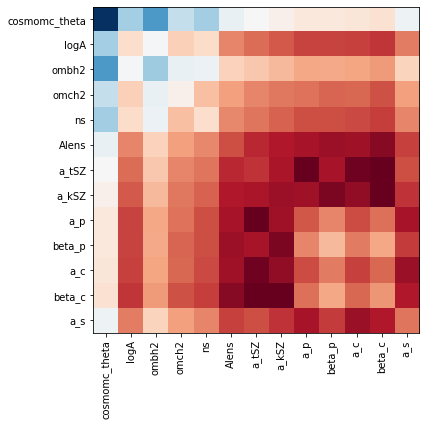

In [23]:
plt.figure(figsize=(6, 6))
plt.imshow(np.log(np.abs(fisher_matrix)), cmap="RdBu")
plt.xticks(np.arange(nparams), fisher_params, rotation=90)
plt.yticks(np.arange(nparams), fisher_params, rotation=0);

and the Fisher estimated noise



In [24]:
fisher_sigmas = np.sqrt(np.diag(np.linalg.inv(fisher_matrix)))
for param_name, param_sigma in zip(fisher_params, fisher_sigmas):
    print("param: {}, sigma: {}, Fisher S/N: {}".format(
        param_name, param_sigma, defaults[param_name]/param_sigma))

param: cosmomc_theta, sigma: 1.399877938734096e-06, Fisher S/N: 7435.29111503276
param: logA, sigma: 0.003441556526517617, Fisher S/N: 884.483511035081
param: ombh2, sigma: 6.262170925624778e-05, Fisher S/N: 357.22435982164035
param: omch2, sigma: 0.0010980367129092713, Fisher S/N: 109.28596338282486
param: ns, sigma: 0.003075681407578369, Fisher S/N: 313.7190990011257
param: Alens, sigma: 0.021324416723904203, Fisher S/N: 46.89460035167208
param: a_tSZ, sigma: 0.03907199656985328, Fisher S/N: 84.4594668741903
param: a_kSZ, sigma: 0.08965105499185613, Fisher S/N: 17.846973470031596
param: a_p, sigma: 0.07022989369829269, Fisher S/N: 98.24876041593299
param: beta_p, sigma: 0.0131531547771269, Fisher S/N: 158.1369667767525
param: a_c, sigma: 0.10341597194710918, Fisher S/N: 47.38146253178421
param: beta_c, sigma: 0.027366723483548145, Fisher S/N: 80.38960167528123
param: a_s, sigma: 0.010809257670433635, Fisher S/N: 286.7912019970968


Let's show the Signal over Noise ratio graphically



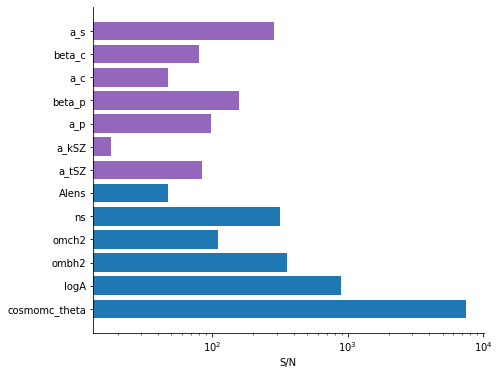

In [25]:
plt.figure(figsize=(7, 6))
SoN = [defaults[param_name]/param_sigma
       for param_name, param_sigma in zip(fisher_params, fisher_sigmas)]
colors = ["tab:blue" if name in cosmo_params else "tab:purple" for name in fisher_params]
plt.barh(np.arange(len(SoN)), SoN, color=colors)
plt.xscale("log")
plt.xlabel("S/N")
plt.yticks(range(len(fisher_params)), fisher_params)
plt.gca().spines["right"].set_color(None)
plt.gca().spines["top"].set_color(None)

It also works for TT, TE or EE mode even if you keep the default list of sampled parameters. It will
only warn you about the fact that some parameters have no effect on power spectra and thus can be
removed from the sampled parameter list.



## Using the MFLike likelihood without cobaya



The `MFLike` likelihood can also be used independently of `cobaya`. The principle is the same as in
this `cobaya`'s [example](https://github.com/CobayaSampler/planck_lensing_external). First we need
to instantiate an `MFLike` object



In [26]:
from mflike import MFLike
my_mflike = MFLike({"path_install": r"/tmp/modules",
                    "input_file": "data_sacc_00000.fits",
                    "cov_Bbl_file": "data_sacc_w_covar_and_Bbl.fits"
})

[mflike.mflike] Initialising.


To compute the log-likelihood value, we can use the `loglike` function which takes as parameters an
theoritical $C_\ell$ dictionary and the nuisance parameter values. The $C_\ell$ dictionary can be,
for instance, retrieved from an independant program or an independant computation. Here we will use
`CAMB` to compute the $C_\ell$ from a cosmological model set by the `cosmo_params`



In [27]:
camb_cosmo = {k: v for k, v in cosmo_params.items()
              if k not in ["logA", "As"]}
camb_cosmo.update({"As": 1e-10*np.exp(cosmo_params["logA"]["value"]),
                   "lmax": lmax, "lens_potential_accuracy": 1})

pars = camb.set_params(**camb_cosmo)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit="muK")
cl_dict = {k: powers["total"][:, v]
           for k, v in {"tt": 0, "ee": 1, "te": 3, "bb": 2}.items()}

Let's plot $C_\ell$ and let's compare them to the ones from `cobaya`



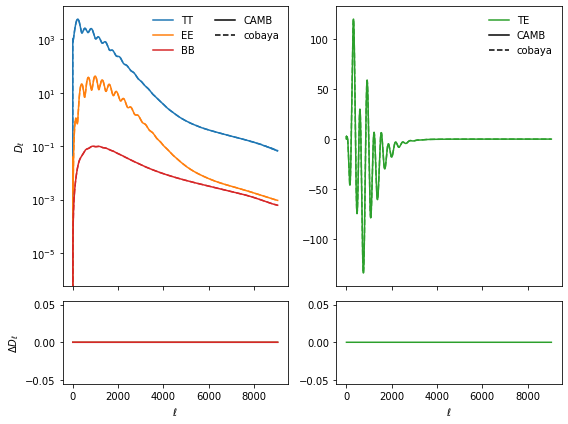

In [28]:
fig = plt.figure(figsize=(8, 6))
gs = plt.GridSpec(4, 2)
axes = {"tt": [fig.add_subplot(gs[0:3, 0], xticklabels=[]), fig.add_subplot(gs[-1, 0])],
        "te": [fig.add_subplot(gs[0:3, 1], xticklabels=[]), fig.add_subplot(gs[-1, 1])]}

l = np.arange(cl_dict["tt"].shape[0])
for i, (k, v) in enumerate(cl_dict.items()):
    plot = axes["te"][0].plot if k == "te" else axes["tt"][0].semilogy
    plot(l, v, "-C{}".format(i), label=k.upper())
    plot(l, Dls[k], "--C{}".format(i))
    ax = axes["te"][1] if k == "te" else axes["tt"][1]
    ax.plot(l, v - Dls[k], "-C{}".format(i))

axes["tt"][0].set_ylabel(r"$D_\ell$")
axes["tt"][1].set_ylabel(r"$\Delta D_\ell$")
for k in axes.keys():
    axes[k][1].set_xlabel(r"$\ell$")
    axes[k][0].plot([], [], "-k", label="CAMB")
    axes[k][0].plot([], [], "--k", label="cobaya")
    axes[k][0].legend(ncol=1 if k == "te" else 2)
plt.tight_layout()

Now we can inject these $C_\ell$ into the `loglike` function to get the corresponding log-likelihood
value



In [ ]:
loglike = my_mflike.loglike(cl_dict, **nuisance_params)
print("log-likelihood value =", loglike)
print("Χ² value =", -2*(loglike))